In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from src.dm import DataModule2 as DataModule
from src.models.unet_ltae import UNetLTAE as Module

In [2]:
import torch 

checkpoint = 'checkpoints/dfta_oc-val_metric=29.47327-epoch=368.ckpt'

hparams = {
	'encoder': 'resnet18',
    'pretrained': 'imagenet',
    'in_channels_s1': 2,
    'in_channels_s2': 6,
    'seq_len': 12,
    'n_head': 16,
}

# module = UNet.load_from_checkpoint(checkpoint)
# module.hparams

state_dict = torch.load(checkpoint)['state_dict']
module = Module(hparams)
module.load_state_dict(state_dict)

<All keys matched successfully>

In [3]:
dm = DataModule(val_size=0.2, num_workers=10, pin_memory=True, batch_size=4)
dm.setup()

train: 6951
val: 1738
test: 2773


In [4]:
from tqdm import tqdm 
import numpy as np

dl = dm.val_dataloader()
module.cuda()
metrics = []
for batch in tqdm(dl):
    x1, x2, y = batch
    preds = module.predict(x1.cuda(), x2.cuda())
    metrics.append(torch.mean(torch.sqrt(torch.mean((preds * 12905.3 - y.cuda() * 12905.3)**2, dim=(1, 2)))))

torch.mean(torch.tensor(metrics)).item()

100%|██████████| 435/435 [00:31<00:00, 13.89it/s]


29.484333038330078

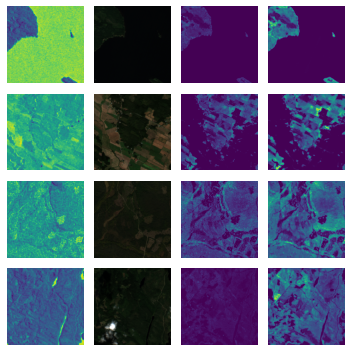

In [10]:
import torch 
import matplotlib.pyplot as plt 

dl = dm.val_dataloader(batch_size=4)
x1, x2, labels = next(iter(dl))
module.cpu()
preds = module.predict(x1, x2)

fig, ax = plt.subplots(4, 4, figsize=(5, 5))
for i in range(4):
	ax[i, 0].imshow(x1[i][0][...,0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(x2[i][0][...,:3])
	ax[i, 1].axis('off')
	ax[i, 2].imshow(labels[i])
	ax[i, 2].axis('off')
	ax[i, 3].imshow(preds[i])
	ax[i, 3].axis('off')
plt.tight_layout()
plt.show()

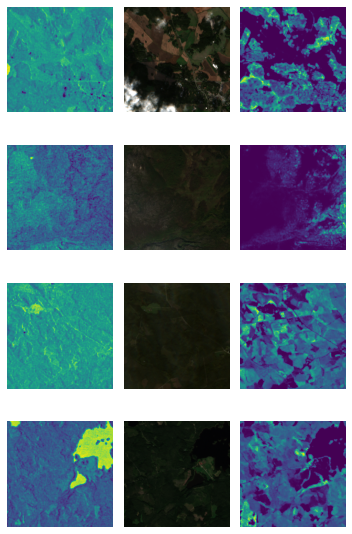

In [11]:
dl = dm.test_dataloader(batch_size=4)
x1, x2, _ = next(iter(dl))

module.cpu()
preds = module.predict(x1, x2)

fig, ax = plt.subplots(4, 3, figsize=(5, 8))
for i in range(4):
	ax[i, 0].imshow(x1[i][0][...,0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(x2[i][0][...,:3,...])
	ax[i, 1].axis('off')
	ax[i, 2].imshow(preds[i])
	ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [14]:
from tqdm import tqdm 
from skimage.io import imsave

dl = dm.test_dataloader(batch_size=4)

# si no tienes 2 gpus pon cuda(0)
module.cuda(1)

for x1, x2, chip_ids in tqdm(dl):
	preds = module.predict(x1.cuda(1), x2.cuda(1))
	# preds = preds*(dm.ds_test.max - dm.ds_test.min) + dm.ds_test.min
	# preds = preds*dm.ds_test.std + dm.ds_test.mean
	preds = preds*12905.3
	for chip_id, pred in zip(chip_ids, preds.cpu().numpy()):
		imsave(f'./submission/{chip_id}_agbm.tif', pred)

100%|██████████| 694/694 [00:52<00:00, 13.27it/s]


In [15]:
import glob 

files = glob.glob('./submission/*.tif')
assert len(files) == 2773

In [16]:
# zip folder 

import shutil
shutil.make_archive('submission', 'zip', './submission')

'/home/juan/Desktop/competis/TheBioMassters/submission.zip'

In [17]:
import rasterio as rio
import numpy as np

ix = np.random.randint(0, len(files))
ds = rio.open(files[ix])

ds.indexes, ds.shape, ds.count

/home/juan/miniconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


((1,), (256, 256), 1)

In [18]:
x = ds.read(1)

x.shape, x.dtype, x.min(), x.max()

((256, 256), dtype('float32'), 6.6090265e-06, 467.583)

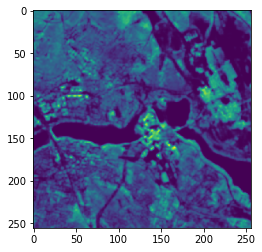

In [19]:
plt.imshow(x)
plt.show()